# House Prices - Processing the data

Based on the work with the EDA and Feature refinement notebooks, start to create a clean dataset that can be used for training a model.

In [23]:
import os
import platform
import pandas as pd
import numpy as np

# Check which platform is running the notebook
if platform.system() == 'Windows':
    PROJECT_PATH = "\\".join(os.getcwd().split('\\')[:-1])
else:
    # Assuming a Unix based platform
    PROJECT_PATH = "/".join(os.getcwd().split('/')[:-1])

DATA_PATH = os.path.join(PROJECT_PATH, 'data')
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train.csv')

# Load the training dataset
house_prices_train = pd.read_csv(TRAIN_DATA_PATH)
house_prices_train = house_prices_train.drop('Id', axis=1)
house_prices_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Defining the columns

Getting the columns that were considered the best ones to use from the EDA notebook

In [24]:
numeric_features = [
    'LotFrontage',
    'LotArea', 'YearBuilt',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF', 
    'GrLivArea', 
    'GarageYrBlt', 
    'GarageArea', 
    'WoodDeckSF', 
    'OpenPorchSF', 
    'EnclosedPorch', 
    'ScreenPorch', 
]

ordinal_features = [
    'GarageCond',
    'GarageQual',
    'FireplaceQu',
    'KitchenQual',
    'HeatingQC',
    'BsmtFinType2',
    'BsmtFinType1',
    'BsmtExposure',
    'BsmtCond',
    'BsmtQual',
    'ExterCond',
    'ExterQual'
]

categorical_features = [
    'MSZoning',
    'Street',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle', 
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating',
    'CentralAir',
    'Electrical',
    'Functional',
    'GarageType',
    'GarageFinish',
    'PavedDrive',
    'SaleType',
    'SaleCondition'
]

Bringing in the processing pipeline class from the EDA notebook

In [25]:
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion

class FeatureExtractor(TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.cols]

class HouseDataProcessor(object):
    def __init__(self, numeric_cols, ordinal_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.ordinal_cols = ordinal_cols
        self.categorical_cols = categorical_cols
        
        self.numeric_pipeline_v1 = Pipeline([
            ('extractor', FeatureExtractor(self.numeric_cols)),
            ('impute', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        self.ordinal_pipeline_v1 = Pipeline([
            ('extractor', FeatureExtractor(self.ordinal_cols)),
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('ordinal', OrdinalEncoder())
        ])

        self.categorical_pipeline_v1 = Pipeline([
            ('extractor', FeatureExtractor(self.categorical_cols)),
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('one_hot', OneHotEncoder())
        ])

        self.processing_pipeline_v1 = FeatureUnion([
            ('numeric', self.numeric_pipeline_v1),
            ('ordinal', self.ordinal_pipeline_v1),
            ('categorical', self.categorical_pipeline_v1)
        ])
        
    def fit(self, X):
        return self.processing_pipeline_v1.fit(X)
    
    def transform(self, X):
        return self.processing_pipeline_v1.transform(X)
    
    def fit_transform(self, X):
        return self.processing_pipeline_v1.fit_transform(X)

## Remove Outlier SalesPrice

Remove the extreme values from the Sale Price so it doesn't skrew the results when making a prediction

In [26]:
sale_price_data = house_prices_train['SalePrice']

q1 = sale_price_data.quantile(0.25)
q3 = sale_price_data.quantile(0.75)
iqr = (q3 - q1)

# Extract the outliers sale price from the data
outliers = house_prices_train[(sale_price_data < (q1 - 1.5 * iqr)) | (sale_price_data > (q3 + 1.5 * iqr))]
outliers.shape

(61, 80)

In [27]:
# Get only the indexes that don't appear in the outlier list
inlier_index = ~house_prices_train.index.isin(outliers.index)

# Remove the outliers from the data 
# So we are left with data that doesn't have extreme outliers
training_data = house_prices_train[inlier_index]
training_data.shape

(1399, 80)

In [28]:
TARGET_FEATURE = 'SalePrice'

# Split into X and y
X = training_data.drop(TARGET_FEATURE, axis=1)
y = training_data[TARGET_FEATURE]

## Creating a training, validation & testing dataset

In [29]:
from sklearn.model_selection import train_test_split

# Set out initial random state
# This will be used by anything that can have its random stat defined
RANDOM_STATE = 11

# Sizes of each dataset
train_size = 0.7
val_size = 0.2
test_size = 0.1

# Creating Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=test_size)

# From the training set, split into trianing and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=RANDOM_STATE, test_size=val_size)

print("Train Size: {:6}".format(X_train.shape[0]))
print("Val Size: {:7}".format(X_val.shape[0]))
print("Test Size: {:6}".format(X_test.shape[0]))

Train Size:   1007
Val Size:     252
Test Size:    140


In [30]:
# TODO - Run the data processing pipeline 
processor = HouseDataProcessor(numeric_features, ordinal_features, categorical_features)
X_train_processed = processor.fit_transform(X_train)

## Modelling

In [31]:
from sklearn.ensemble import RandomForestRegressor

# Train a random forest regressor
rand_clf_v1 = RandomForestRegressor(random_state=RANDOM_STATE)
rand_clf_v1.fit(X_train_processed, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=11, verbose=0, warm_start=False)

In [32]:
from sklearn.metrics import mean_squared_error

# Seeing a baseline with a basic random forest
y_pred = rand_clf_v1.predict(X_train_processed)

mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print('Random Forest V1 RMSE: ', rmse)

Random Forest V1 RMSE:  8610.330891854


For  baseline score, being around \$8000 in terms of error isn't to bad considered we are dealing with houses that are in the hundreds of thousands. I will now try to improve this result.

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_estimators': [100, 150, 200, 250, 300, 350],
        'criterion': ['mse', 'mae'],
        'warm_start': [True, False]
    }
]

rand_forest_v2 = RandomForestRegressor(random_state=RANDOM_STATE)
grid_search_v1 = GridSearchCV(rand_forest_v2, param_grid, cv=3, n_jobs=2 , 
                              verbose=1, scoring='neg_mean_squared_error')
grid_search_v1.fit(X_train_processed, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  72 out of  72 | elapsed:  7.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=11,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [34]:
grid_search_v1.best_params_

{'criterion': 'mae', 'n_estimators': 350, 'warm_start': True}

In [35]:
np.sqrt(-grid_search_v1.best_score_)

24004.819779636346

In [36]:
best_estimator = grid_search_v1.best_estimator_

y_pred = best_estimator.predict(X_train_processed)

mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print('Random Forest V2 (Grid Search) RMSE: ', rmse)

Random Forest V2 (Grid Search) RMSE:  8498.796786810319


By performing the grid search, we have managed to reduce the error rate by around $200 dollers. However, the grid search reached the maximum parameters. I will now do a second round of training with more estimators to see if that improves things even further.

In [37]:
param_grid = [
    {
        'n_estimators': [350, 400, 450, 500, 550, 600],
        'criterion': ['mae'],
        'warm_start': [True]
    }
]

rand_forest_v3 = RandomForestRegressor(random_state=RANDOM_STATE)
grid_search_v2 = GridSearchCV(rand_forest_v3, param_grid, cv=3, n_jobs=2 , 
                              verbose=1, scoring='neg_mean_squared_error')
grid_search_v2.fit(X_train_processed, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:  6.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=11,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [38]:
grid_search_v2.best_params_

{'criterion': 'mae', 'n_estimators': 550, 'warm_start': True}

In [39]:
np.sqrt(-grid_search_v2.best_score_)

23971.549576257556

In [40]:
grid_search_best_est_v2 = grid_search_v2.best_estimator_

y_pred = grid_search_best_est_v2.predict(X_train_processed)

mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print('Random Forest V3 (Grid Search v2) RMSE: ', rmse)

Random Forest V3 (Grid Search v2) RMSE:  8425.62355763698


A very minor improvement for using the Random Forest model. From this, we can see that we need to apply some feature engineering to reduce the amount of features.

In [41]:
# Extract the most important features from the best model
feature_importance = grid_search_best_est_v2.feature_importances_

# Extract the all the one-hot categorical features
categorical_labels = np.concatenate(processor.categorical_pipeline_v1['one_hot'].categories_)

# Combine to a single array of labels
all_labels = np.concatenate([numeric_features, ordinal_features, categorical_labels])

sorted_features_index = feature_importance.argsort()[::-1]
top_100_features_index = sorted_features_index[0:100]

# See the top 100 features
all_labels[top_100_features_index]

array(['GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageArea', '1stFlrSF',
       'ExterQual', 'BsmtFinSF1', 'LotArea', 'LotFrontage', 'BsmtUnfSF',
       'GarageYrBlt', '2ndFlrSF', 'OpenPorchSF', 'MasVnrArea', 'BsmtQual',
       'Unf', 'WoodDeckSF', 'KitchenQual', 'BsmtFinType1', 'Crawfor',
       'BsmtExposure', 'HeatingQC', 'EnclosedPorch', 'BsmtFinSF2',
       'ScreenPorch', 'RL', 'ExterCond', 'FireplaceQu', 'Fin', '1Fam',
       'Attchd', 'RFn', 'Inside', 'Detchd', 'N', 'IR1', 'Reg', 'BsmtCond',
       'Abnorml', 'Gable', 'Typ', 'Normal', 'Y', 'Corner', 'BsmtFinType2',
       'Hip', 'CollgCr', 'BrkFace', 'CBlock', 'Edwards', 'Norm', 'RM',
       'Stone', 'CulDSac', 'VinylSd', 'NAmes', 'VinylSd', 'Lvl', 'PConc',
       'BrkFace', 'Wd Sdng', 'NWAmes', 'Family', 'MetalSd', 'None',
       'NridgHt', 'Wd Sdng', 'HdBoard', 'MetalSd', '1.5Fin', 'SLvl',
       '1Story', 'FR2', 'WD', 'Plywood', 'Plywood', 'Y', 'HdBoard',
       'Sawyer', 'Duplex', '2Story', 'ClearCr', 'Gtl', 'Mitchel', 'Mod

In [42]:
# Reduce the training dataset to only have the top 100 features
X_train_top_100_processed = X_train_processed.toarray()[:, top_100_features_index]
X_train_top_100_processed.shape

(1007, 100)

In [22]:
rand_forest_v4 = RandomForestRegressor(random_state=RANDOM_STATE)
rand_forest_v4.fit(X_train_top_100_processed, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=11, verbose=0, warm_start=False)

In [43]:
y_pred = rand_forest_v4.predict(X_train_top_100_processed)

mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print('Random Forest V4 (Top 100 features) RMSE: ', rmse)

Random Forest V4 (Top 100 features) RMSE:  8573.330968836264


From reducing it to the top 100 features from the Random Forest regressor, there has been a slight improvement from the original base model. I will now train it with the best from the last round grid search (v2), to see how it performs.

In [44]:
%%time
params = grid_search_v2.best_params_
rand_forest_v5 = RandomForestRegressor(random_state=RANDOM_STATE, **params)
rand_forest_v5.fit(X_train_top_100_processed, y_train)

Wall time: 58.4 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=550, n_jobs=None, oob_score=False,
                      random_state=11, verbose=0, warm_start=True)

In [45]:
def get_rmse_score(clf, X, y):
    y_pred = clf.predict(X)

    mse = mean_squared_error(y, y_pred)
    return np.sqrt(mse)

In [46]:
rmse = get_rmse_score(rand_forest_v5, X_train_top_100_processed, y_train)
print('Random Forest V5 (Top 100 features Best Params) RMSE: ', rmse)

Random Forest V5 (Top 100 features Best Params) RMSE:  8367.874600055844


Compared to the original baseline model that had the same params, this model is again slightly better since it has less dimensions to work with. Originally the score was 8425.62. So a slight improvement. I will now try reducing even more features to see how that affects the error score.

In [47]:
feature_importance = rand_forest_v5.feature_importances_
sorted_features_index = feature_importance.argsort()[::-1]
top_50_features = sorted_features_index[0:50]

# View the new top 50 features
all_labels[top_100_features_index][top_50_features]

array(['GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageArea', '1stFlrSF',
       'ExterQual', 'LotArea', 'BsmtFinSF1', 'LotFrontage', 'BsmtUnfSF',
       'GarageYrBlt', '2ndFlrSF', 'OpenPorchSF', 'MasVnrArea', 'BsmtQual',
       'WoodDeckSF', 'Unf', 'KitchenQual', 'BsmtFinType1', 'Crawfor',
       'BsmtExposure', 'HeatingQC', 'EnclosedPorch', 'ScreenPorch', 'RL',
       'ExterCond', 'BsmtFinSF2', 'FireplaceQu', 'Fin', '1Fam', 'Attchd',
       'RFn', 'N', 'Typ', 'Normal', 'Abnorml', 'BsmtCond', 'Reg',
       'Detchd', 'Inside', 'IR1', 'Hip', 'BsmtFinType2', 'Gable', 'Norm',
       'Y', 'Corner', 'Edwards', 'CollgCr', 'BrkFace'], dtype=object)

In [48]:
# Extract the top 50
X_train_top_50_processed = X_train_top_100_processed[:, top_50_features]

In [49]:
%%time
rand_forest_v6 = RandomForestRegressor(random_state=RANDOM_STATE, **params)
rand_forest_v6.fit(X_train_top_50_processed, y_train)

Wall time: 34 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=550, n_jobs=None, oob_score=False,
                      random_state=11, verbose=0, warm_start=True)

In [50]:
rmse = get_rmse_score(rand_forest_v6, X_train_top_50_processed, y_train)
print('Random Forest V6 (Top 50 features Best Params) RMSE: ', rmse)

Random Forest V6 (Top 50 features Best Params) RMSE:  8384.057470490958


From looking at the leaderboards from the Kaggle comptition, the Root Mean squared logarithmic error is the lost function that is used to meansure how good the model is. So I will now apply this to the model to see the results

In [52]:
from sklearn.metrics import mean_squared_log_error

def get_root_mean_squared_log_error(clf, X, y):
    y_pred = clf.predict(X)
    return np.sqrt(mean_squared_log_error(y, y_pred))

rmsle = get_root_mean_squared_log_error(rand_forest_v6, X_train_top_50_processed, y_train)
print('RMSLE Random Forest V6: {:.6f}'.format(rmsle))

RMSLE Random Forest V6: 0.058563


Looking at the results on Kaggle, the best is 0.00044. If the training result was repesentive of the test set, that would put us around 60th place. I will apply some cross validation to see how it performs.

In [54]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rand_forest_v6, X_train_top_50_processed, y_train, cv=3, scoring='neg_mean_squared_log_error')

In [59]:
print('Mean RMSLE Cross Val Random Forest V6: {:.6f}'.format(np.sqrt(-scores).mean()))

Mean RMSLE Cross Val Random Forest V6: 0.150495


This results shows a more likely outcome of the model on a test dataset. This result puts us deep down on the average for this dataset.

I will now try using a few others, to see if there is any more we can get from this dataset before applying PCA or manifold approaches to reudce the number of dimensions.

In [60]:
from sklearn.linear_model import BayesianRidge, Ridge, PassiveAggressiveRegressor
from sklearn.svm import SVR, LinearSVR

clfs = [
    BayesianRidge(),
    Ridge(random_state=RANDOM_STATE),
    PassiveAggressiveRegressor(random_state=RANDOM_STATE),
    SVR(),
    LinearSVR(random_state=RANDOM_STATE)
]

for idx, clf in enumerate(clfs):
    clf.fit(X_train_top_50_processed, y_train)
    
    rmsle = get_root_mean_squared_log_error(clf, X_train_top_50_processed, y_train)
    print('{}: {} - RMSLE {:.6f}'.format(idx, clf.__class__.__name__, rmsle ))

0: BayesianRidge - RMSLE 0.137411
1: Ridge - RMSLE 0.137782
2: PassiveAggressiveRegressor - RMSLE 0.175888
3: SVR - RMSLE 0.361092
4: LinearSVR - RMSLE 0.835692


From trying baseline models, so far the random forest approach seems to still be hsowing the best training RMSLE. I will now look are refining the results further with PCA / manifold learning.

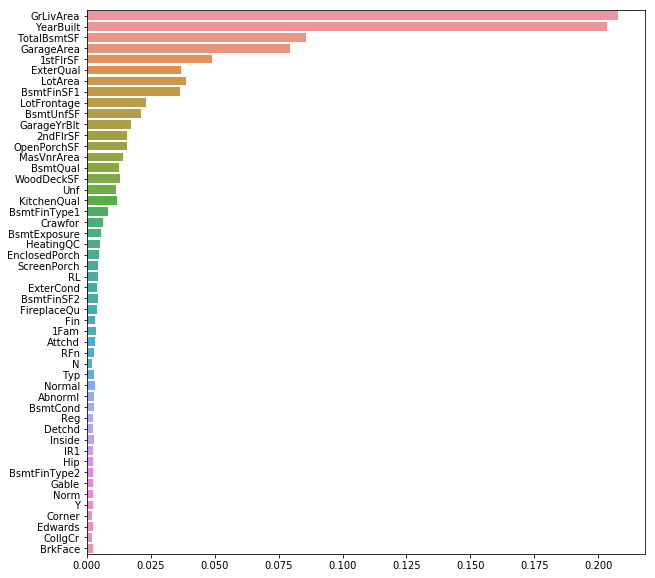

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualising the most important features
top_50_labels = all_labels[top_100_features_index][top_50_features]
feature_importance = rand_forest_v6.feature_importances_

plt.figure(figsize=(10, 10))
sns.barplot(feature_importance, top_50_labels)
plt.show()

In [71]:
from sklearn.decomposition import PCA

pca_v1 = PCA(n_components=0.99, random_state=RANDOM_STATE)
X_train_pca = pca_v1.fit_transform(X_train_top_50_processed)
X_train_pca.shape

(1007, 37)

In [70]:
# Number of components with 99% explained variance
pca_v1.n_components_

37

From applying PCA, we have reduce the dataset from 50 features to 37. Now I will apply the random forest regressor to this data

In [72]:
rand_forest_v7 = RandomForestRegressor(random_state=RANDOM_STATE, **params)
rand_forest_v7.fit(X_train_pca, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=550, n_jobs=None, oob_score=False,
                      random_state=11, verbose=0, warm_start=True)

In [74]:
rmsle = get_root_mean_squared_log_error(rand_forest_v7, X_train_pca, y_train)
print('RMSLE Random Forest V7 (PCA): {:.6f}'.format(rmsle))

RMSLE Random Forest V7 (PCA): 0.066379


In [75]:
scores = cross_val_score(rand_forest_v7, X_train_pca, y_train, cv=3, scoring='neg_mean_squared_log_error')

In [78]:
print('Mean RMSLE Cross Val Random Forest V7: {:.6f}'.format(np.sqrt(-scores).mean()))

Mean RMSLE Cross Val Random Forest V7: 0.171054


Compared to the previous models, using the PCA approach has resulted in a slight worse model.

Considering that given the current data, we have reached the best results so far, I will now try it on the validation data to see how the v6 and v7 models perform.